## Introduction 
Autoencoder are special type of deep learning architecture that consist of two networks encoder and decoder.
The encoder, through a series of CNN and downsampling, learns a reduced dimensional representation of the input data while decoder  through the use of CNN and upsampling, attempts to regenerate the data from the these representations. A well-trained decoder is able to regenerated data that is identical or as close as possible to the original input data.
Autoencoder are generally used for anamoly detection, denoising image, colorizing the images. Here, i am going to colorize the landscape images using autoencoder.

<img src = 'https://miro.medium.com/max/600/1*nqzWupxC60iAH2dYrFT78Q.png' >

## Image Colorization
Image colorization using different softwares require large amount of human effort, time and skill.But special type of deep learning architecture called autoencoder has made this task quiet easy. Automatic image colorization often involves the use of a class of convolutional neural networks (CNN) called autoencoders. These neural networks are able to distill the salient features of an image, and then regenerate the image based on these learned features. 

<img src = "https://tinyclouds.org/colorize/best/6.jpg">

## Import necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

### Getting landscape image data,resizing them and appending in array
To get the image in sorted order i have defined the function sorted_alphanumeric. Here, I have used open cv library to read and resize images. Finally images are normalized and are converted to array and are appended in empty list

In [13]:
# to get the files in proper order
from pathlib import Path

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = Path(os.getcwd()) / "archive" / "landscape Images" / "color"
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(str(path) + '/' + i, 1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = Path(os.getcwd()) / "archive" / "landscape Images" / "gray"
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(str(path) + '/' + i, 1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))
         
   

 84%|████████▍ | 6000/7129 [00:06<00:01, 898.64it/s] 


### Plotting Color image and it's corresponding grayscale image

In [14]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

**Plotting image pair**

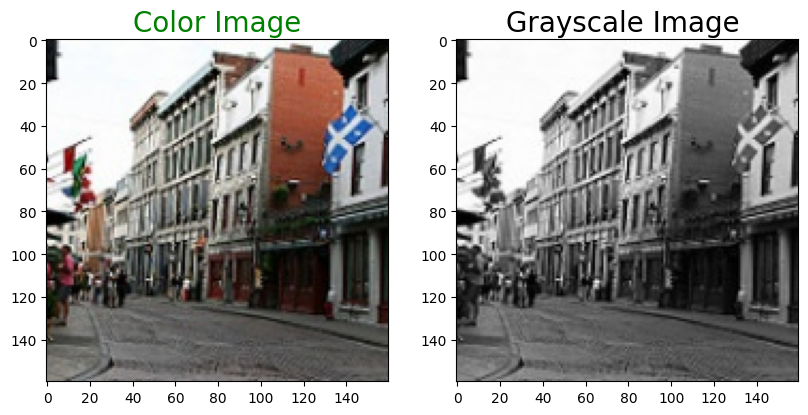

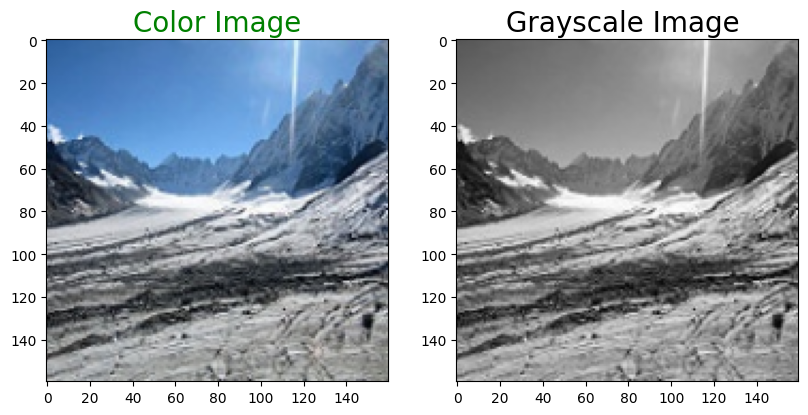

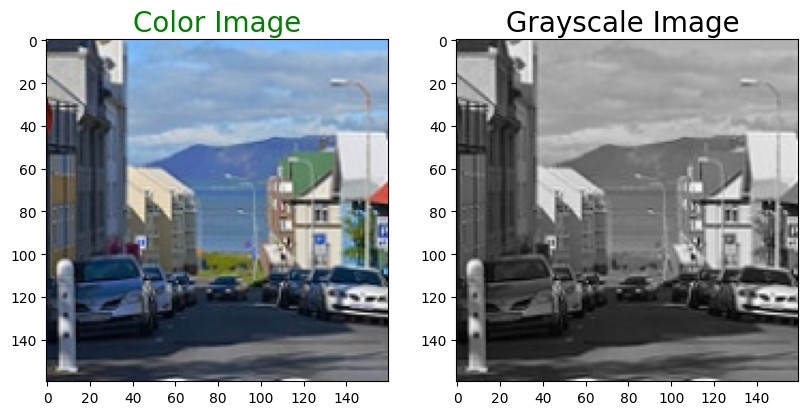

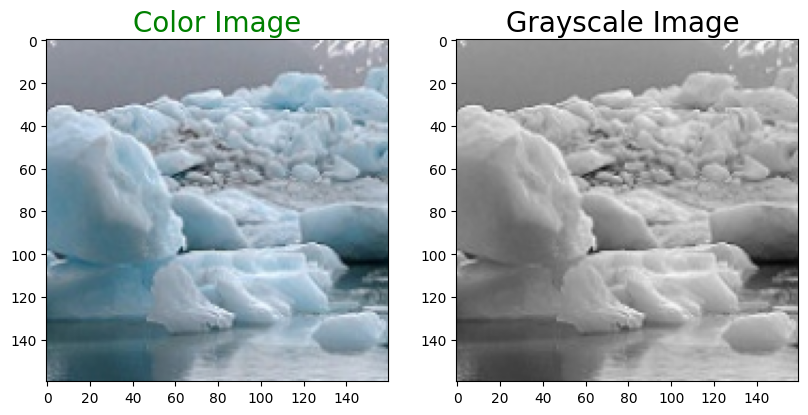

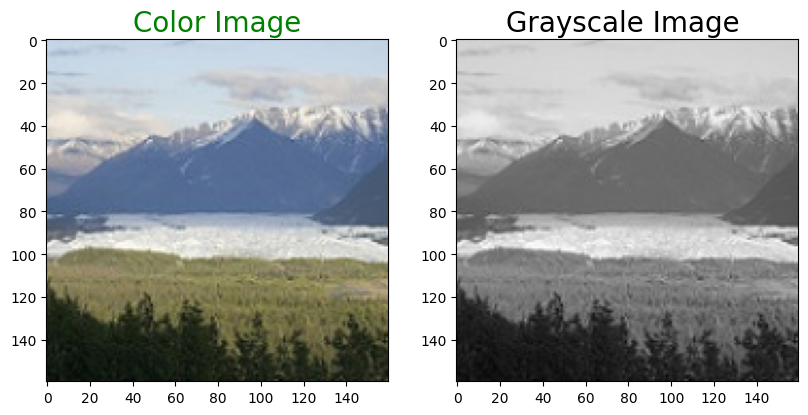

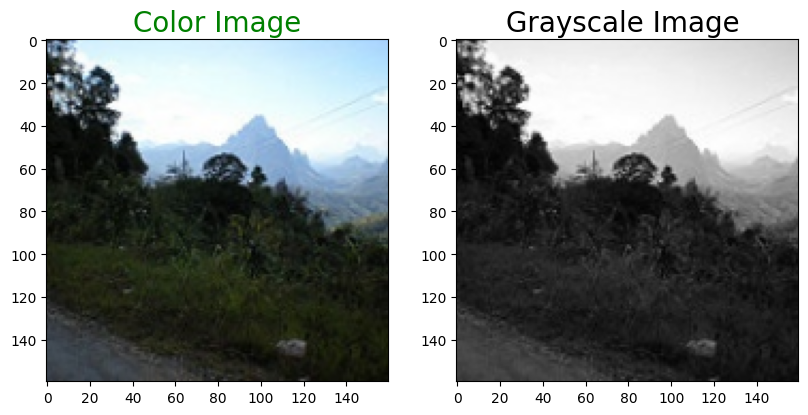

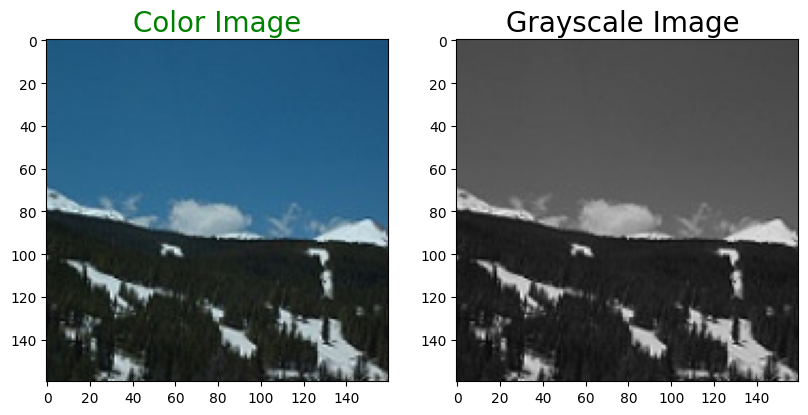

In [15]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

### Slicing and reshaping
Out of 5000 images I have sliced them to two part. train images consist 4000 images  while test images contains 1000 images.
After slicing the image array, I reshaped them so that images can be fed directly into our encoder network

In [17]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


## Defining our model
Encoder layer of our model consist blocks of Convolution layer with different number of kernel and kernel_size. Here, Convolution is used for downsampling.
Similary, Decoder layer of our model consist of  transpose convolution layer with different kernel size. Here, Decoder layer upsample image downsampled by encoder.
Since there is feature loss between the encoder and decoder layers so inorder to prevent feature loss i have concatenate corresponding encoder and decoder layers. Check U_Net architecture for better understanding......

In [18]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


In [29]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [30]:
model = model()
model.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_30       │ (None, 80, 80,    │      3,584 │ input_layer_33[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_31       │ (None, 40, 40,    │    147,584 │ sequential_30[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_32       │ (None, 20, 20,    │    296,192 │ sequential_31[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_33       │ (None, 10, 10,    │  1,182,208 │ sequential_32[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_34       │ (None, 5, 5, 512) │  2,361,856 │ sequential_33[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_35       │ (None, 10, 10,    │  2,359,808 │ sequential_34[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 10, 10,    │          0 │ sequential_35[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_33[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_36       │ (None, 20, 20,    │  2,359,552 │ concatenate_15[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 20, 20,    │          0 │ sequential_36[0]… │
│ (Concatenate)       │ 512)              │            │ sequential_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_37       │ (None, 40, 40,    │    589,952 │ concatenate_16[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 40, 40,    │          0 │ sequential_37[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_38       │ (None, 80, 80,    │    295,040 │ concatenate_17[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 80, 80,    │          0 │ sequential_38[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_39       │ (None, 160, 160,  │      6,915 │ concatenate_18[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 160, 160,  │          0 │ sequential_39[0]… │
│ (Concatenate)       │ 6)                │            │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 160, 160,  │         75 │ concatenate_19[0

 Total params: 9,602,766 (36.63 MB)

 Trainable params: 9,600,206 (36.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

### Fitting our model

In [31]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 50,batch_size = 50,verbose = 1)

ERROR! Session/line number was not unique in database. History logging moved to new session 6
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - acc: 0.5363 - loss: 0.0464
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - acc: 0.5531 - loss: 0.0438
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - acc: 0.5568 - loss: 0.0441
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - acc: 0.5652 - loss: 0.0425
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.5785 - loss: 0.0421
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.5903 - loss: 0.0415
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.5986 - loss: 0.0410
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - acc: 0.6057 - loss: 0.0401
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.6082 - loss: 0.0395
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.6117 - loss: 0.0390
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - acc: 0.6194 - loss: 0.0380
Ep

In [32]:
model.evaluate(test_gray_image,test_color_image)
model.save("gray2color-model.keras")

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 599ms/step - acc: 0.5483 - loss: 0.0479


# plotting colorized image along with grayscale and color image

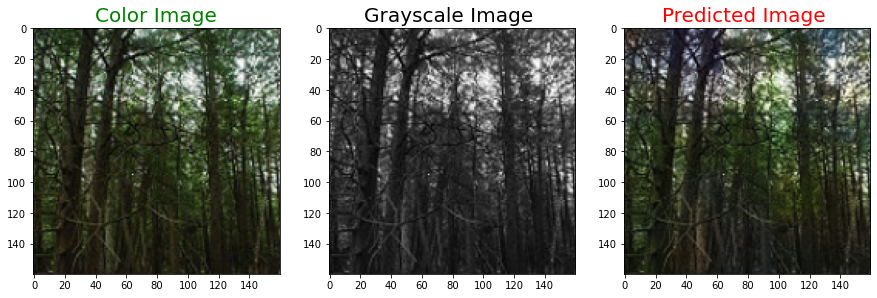

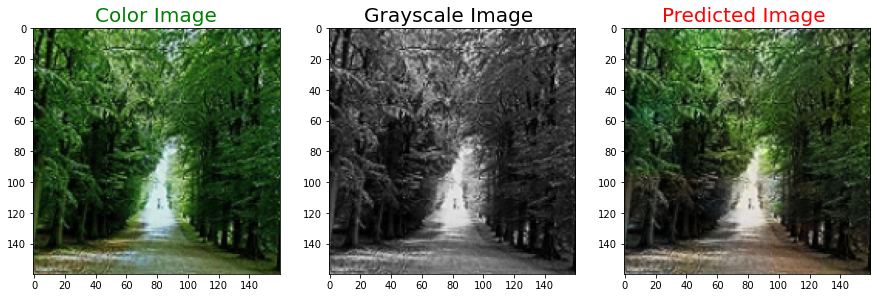

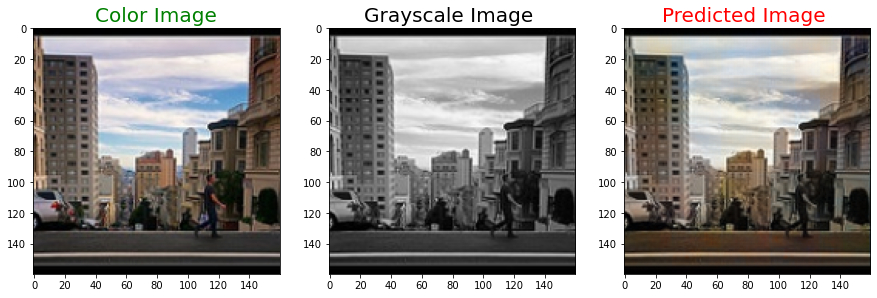

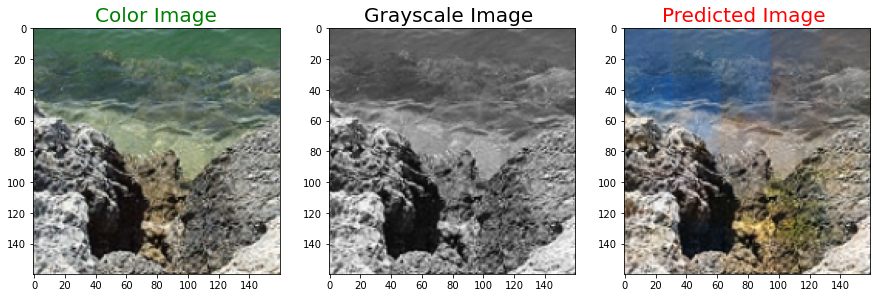

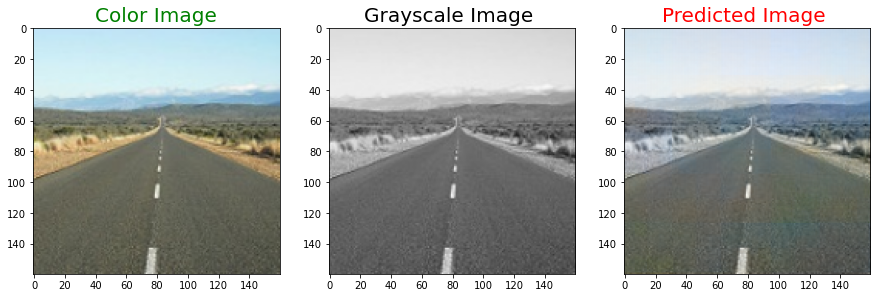

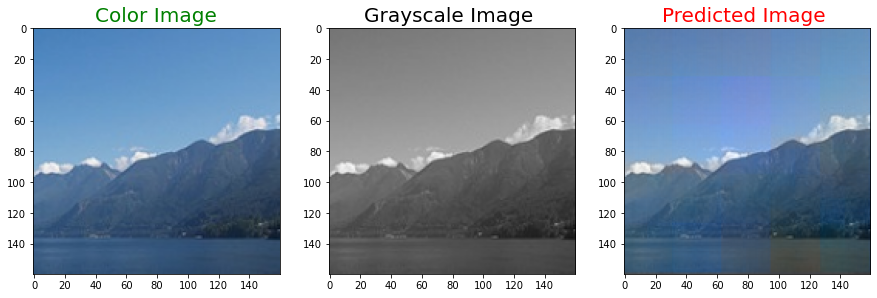

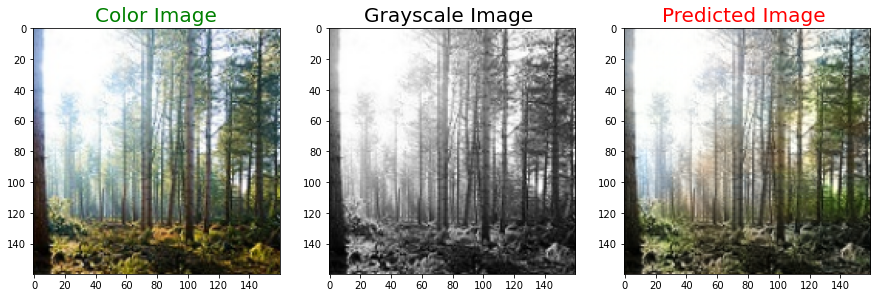

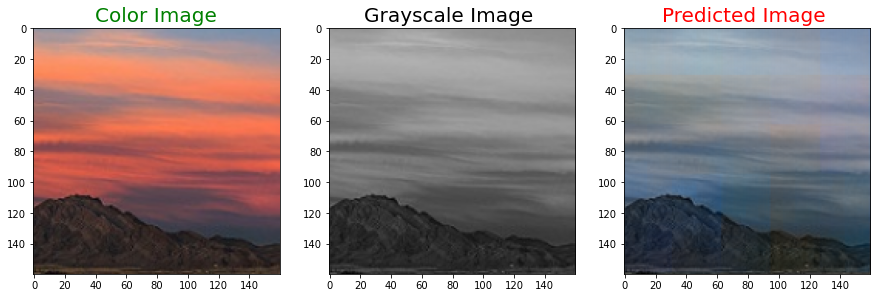

In [17]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(50,58):
    predicted = np.clip(model._predict(test_gray_image[i].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

 

# Thanks for your visit.
## Any suggestions to improve this model is highly appreciated.
# Feel free to  comment